## Dataset

In [1]:
import aif360.datasets
import lale.lib.aif360
orig_ds = aif360.datasets.AdultDataset()
fairness_info = lale.lib.aif360.dataset_fairness_info(orig_ds)
fairness_info

/home/hirzel/python3.6venv/lib/python3.6/site-packages/aif360/datasets/standard_dataset.py:121: FutureWarning: outer method for ufunc <ufunc 'equal'> is not implemented on pandas objects. Returning an ndarray, but in the future this will raise a 'NotImplementedError'. Consider explicitly converting the Series to an array with '.array' first.
  priv = np.logical_or.reduce(np.equal.outer(vals, df[attr]))
/home/hirzel/python3.6venv/lib/python3.6/site-packages/aif360/datasets/standard_dataset.py:142: FutureWarning: outer method for ufunc <ufunc 'equal'> is not implemented on pandas objects. Returning an ndarray, but in the future this will raise a 'NotImplementedError'. Consider explicitly converting the Series to an array with '.array' first.
  df[label_name]))


{'favorable_label': 1.0,
 'unfavorable_label': 0.0,
 'protected_attribute_names': ['race', 'sex'],
 'unprivileged_groups': [{'race': 0.0, 'sex': 0.0}],
 'privileged_groups': [{'race': 1.0, 'sex': 1.0}]}

In [2]:
import pandas as pd
from lale.lib.aif360 import dataset_to_pandas
#using only 25% of the data so this notebook runs faster
used_ds, ignore_ds = orig_ds.split([0.25], shuffle=True, seed=42)
train_ds, test_ds = used_ds.split([0.7])
train_X, train_y = dataset_to_pandas(train_ds)
test_X, test_y = dataset_to_pandas(test_ds)
print(f'shapes: train_X {train_X.shape}, train_y {train_y.shape}, test_X {test_X.shape}, test_y {test_y.shape}')
pd.concat([train_y.head(), train_X.head()], axis=1)

shapes: train_X (7913, 98), train_y (7913,), test_X (3392, 98), test_y (3392,)


,income-per-year,age,education-num,race,sex,capital-gain,capital-loss,hours-per-week,workclass=Federal-gov,workclass=Local-gov,...,native-country=Portugal,native-country=Puerto-Rico,native-country=Scotland,native-country=South,native-country=Taiwan,native-country=Thailand,native-country=Trinadad&Tobago,native-country=United-States,native-country=Vietnam,native-country=Yugoslavia
0,1.0,28.0,14.0,1.0,1.0,0.0,0.0,45.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.0,60.0,5.0,1.0,1.0,0.0,0.0,45.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
2,0.0,43.0,10.0,1.0,1.0,0.0,1669.0,45.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
3,0.0,35.0,9.0,1.0,1.0,0.0,0.0,40.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
4,1.0,36.0,10.0,1.0,1.0,0.0,0.0,40.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0


## Search Initial Pipeline

In [3]:
from sklearn.decomposition import PCA
from lale.lib.lale import NoOp
from sklearn.linear_model import LogisticRegression as LR
from xgboost import XGBClassifier as XGBoost
import lale
lale.wrap_imported_operators()

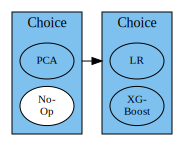

In [4]:
initial_planned = (PCA | NoOp) >> (LR | XGBoost)
initial_planned.visualize()

In [5]:
from lale.lib.lale import Hyperopt
initial_trained = initial_planned.auto_configure(
    train_X, train_y, optimizer=Hyperopt, cv=3, max_evals=3)

100%|██████████| 3/3 [00:34<00:00, 14.73s/trial, best loss: -0.813349862426007]


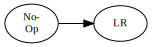

```python
lr = LR(C=1327.7214911678875, dual=True, tol=0.0856386428135445)
pipeline = NoOp() >> lr
```

In [6]:
initial_trained.visualize()
initial_trained.pretty_print(ipython_display=True, show_imports=False)

## Evaluate Initial Pipeline

In [7]:
#accuracy, ideal 100%, higher values indicate better predictive performance
import sklearn.metrics
accuracy_scorer = sklearn.metrics.make_scorer(sklearn.metrics.accuracy_score)
print(f'accuracy {accuracy_scorer(initial_trained, test_X, test_y):.1%}')

accuracy 83.1%


In [8]:
#statistical parity difference, ideal 0, fair between -0.1 and +0.1
stat_par_scorer = lale.lib.aif360.statistical_parity_difference(**fairness_info)
print(f'statistical parity difference {stat_par_scorer(initial_trained, test_X, test_y):.2f}')

statistical parity difference -0.26


In [9]:
#disparate impact, ideal 1, fair between 0.8 and 1.2
disparate_impact_scorer = lale.lib.aif360.disparate_impact(**fairness_info)
print(f'disparate impact {disparate_impact_scorer(initial_trained, test_X, test_y):.2f}')

disparate impact 0.25


## Equalized Odds Postprocessing

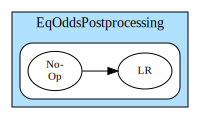

In [10]:
from lale.lib.aif360 import EqOddsPostprocessing
eqodds_trainable = EqOddsPostprocessing(
    estimator=initial_trained, **fairness_info)
eqodds_trainable.visualize()

In [11]:
%%time
eqodds_trained = eqodds_trainable.fit(train_X, train_y)

CPU times: user 1.73 s, sys: 172 ms, total: 1.91 s
Wall time: 2.21 s


In [12]:
print(f'accuracy {accuracy_scorer(eqodds_trained, test_X, test_y):.1%}')
print(f'statistical parity difference {stat_par_scorer(eqodds_trained, test_X, test_y):.2f}')
print(f'disparate impact {disparate_impact_scorer(eqodds_trained, test_X, test_y):.2f}')

accuracy 73.6%
statistical parity difference 0.01
disparate impact 1.02


## Calibrated Equalized Odds Postprocessing

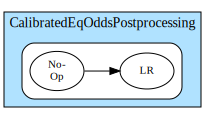

In [13]:
from lale.lib.aif360 import CalibratedEqOddsPostprocessing
caleqo_trainable = CalibratedEqOddsPostprocessing(
    estimator=initial_trained, **fairness_info)
caleqo_trainable.visualize()

In [14]:
%%time
caleqo_trained = caleqo_trainable.fit(train_X, train_y)

CPU times: user 2.23 s, sys: 250 ms, total: 2.48 s
Wall time: 2.61 s


In [15]:
print(f'accuracy {accuracy_scorer(caleqo_trained, test_X, test_y):.1%}')
print(f'statistical parity difference {stat_par_scorer(caleqo_trained, test_X, test_y):.2f}')
print(f'disparate impact {disparate_impact_scorer(caleqo_trained, test_X, test_y):.2f}')

accuracy 75.5%
statistical parity difference 0.02
disparate impact inf


## Reject Option Classification Postprocessing

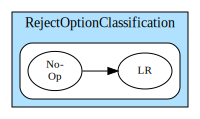

In [16]:
from lale.lib.aif360 import RejectOptionClassification
rejopt_trainable = RejectOptionClassification(
    estimator=initial_trained, **fairness_info)
rejopt_trainable.visualize()

In [17]:
%%time
rejopt_trained = rejopt_trainable.fit(train_X, train_y)

CPU times: user 56.1 s, sys: 3.89 s, total: 1min
Wall time: 1min 8s


In [18]:
print(f'accuracy {accuracy_scorer(rejopt_trained, test_X, test_y):.1%}')
print(f'statistical parity difference {stat_par_scorer(rejopt_trained, test_X, test_y):.2f}')
print(f'disparate impact {disparate_impact_scorer(rejopt_trained, test_X, test_y):.2f}')

accuracy 75.9%
statistical parity difference 0.05
disparate impact inf
